In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

In [2]:
# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_csv("processed_data.csv")

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 6)


### Task 4 : Satisfaction Analysis

### 4.1 engagement score and experience score for each user

In [3]:
# -----------------------
# Helper functions
# -----------------------
def find_col(cols, keywords):
    keys = [k.lower() for k in keywords]
    for c in cols:
        lc = c.lower()
        for k in keys:
            if k in lc:
                return c
    return None

def replace_num_na_with_mean(df, cols):
    for c in cols:
        if c in df.columns:
            if df[c].isnull().any():
                df[c].fillna(df[c].mean(), inplace=True)

def replace_cat_na_with_mode(df, cols):
    for c in cols:
        if c in df.columns:
            if df[c].isnull().any():
                try:
                    df[c].fillna(df[c].mode().iloc[0], inplace=True)
                except:
                    df[c].fillna("", inplace=True)

def treat_outliers_zscore(df, cols, thresh=3.0):
    for c in cols:
        if c in df.columns:
            if pd.api.types.is_numeric_dtype(df[c]):
                m = df[c].mean()
                s = df[c].std()
                if s == 0 or np.isnan(s):
                    continue
                z = (df[c] - m) / s
                mask = z.abs() > thresh
                if mask.any():
                    df.loc[mask, c] = m

# -----------------------
# Load dataset (adjust path if needed)
# -----------------------
INPUT = "telcom_data (2).xlsx - Sheet1.csv"
df = pd.read_csv(INPUT)

# -----------------------
# Detect columns (robust)
# -----------------------
cols = df.columns.tolist()
msisdn_col = find_col(cols, ["msisdn", "number", "phone"])
tcp_col = find_col(cols, ["tcp", "retrans", "retransmission"])
rtt_col = find_col(cols, ["rtt", "round trip", "round-trip"])
throughput_col = find_col(cols, ["throughput", "thrp", "thput", "kbps"])
handset_col = find_col(cols, ["handset", "device", "model", "handset type", "imei"])

# safety checks
if msisdn_col is None:
    raise KeyError("Could not find MSISDN/Number column. Please provide correct dataset or column name.")

print("Using columns:")
print("MSISDN:", msisdn_col)
print("TCP:", tcp_col)
print("RTT:", rtt_col)
print("Throughput:", throughput_col)
print("Handset:", handset_col)

# -----------------------
# Basic cleaning (numeric missing -> mean; categorical missing -> mode)
# and treat outliers by Z-score replacement with mean
# -----------------------
numeric_cols_to_clean = []
for c in [tcp_col, rtt_col, throughput_col, "Dur. (ms)", "Total DL (Bytes)", "Total UL (Bytes)"]:
    if c and c in df.columns:
        numeric_cols_to_clean.append(c)

replace_num_na_with_mean(df, numeric_cols_to_clean)
if handset_col is not None:
    replace_cat_na_with_mode(df, [handset_col])
treat_outliers_zscore(df, numeric_cols_to_clean, thresh=3.0)

# -----------------------
# Build engagement metrics per user (as used earlier)
# sessions_frequency, total_session_duration_min, total_traffic_bytes, avg_session_duration_min
# -----------------------
agg = df.groupby(msisdn_col).agg(
    sessions_frequency = ("Bearer Id", "count"),
    total_session_duration_ms = ("Dur. (ms)", "sum"),
    total_dl=("Total DL (Bytes)", "sum") if "Total DL (Bytes)" in df.columns else (df.columns[0], "count"),
    total_ul=("Total UL (Bytes)", "sum") if "Total UL (Bytes)" in df.columns else (df.columns[0], "count")
).reset_index().rename(columns={msisdn_col: "MSISDN"})

agg["total_traffic_bytes"] = agg["total_dl"].fillna(0) + agg["total_ul"].fillna(0)
agg["total_session_duration_min"] = agg["total_session_duration_ms"].fillna(0) / (1000 * 60)
agg["avg_session_duration_min"] = agg["total_session_duration_min"] / agg["sessions_frequency"].replace(0, np.nan)
agg.fillna(0, inplace=True)

# -----------------------
# Build experience metrics per user
# avg_tcp_retransmission, avg_rtt, avg_throughput, handset (mode)
# -----------------------
grouped = df.groupby(msisdn_col)
if tcp_col is not None:
    avg_tcp = grouped[tcp_col].mean().rename("avg_tcp_retransmission")
else:
    avg_tcp = pd.Series(0.0, index=grouped.size().index, name="avg_tcp_retransmission")

if rtt_col is not None:
    avg_rtt = grouped[rtt_col].mean().rename("avg_rtt")
else:
    avg_rtt = pd.Series(0.0, index=grouped.size().index, name="avg_rtt")

if throughput_col is not None:
    avg_thr = grouped[throughput_col].mean().rename("avg_throughput")
else:
    avg_thr = pd.Series(0.0, index=grouped.size().index, name="avg_throughput")

# handset mode per user
def mode_series(s):
    try:
        return s.mode().iloc[0]
    except:
        return "Unknown"

if handset_col is not None:
    handset_mode = grouped[handset_col].agg(lambda s: mode_series(s)).rename("handset_type")
else:
    handset_mode = pd.Series("Unknown", index=grouped.size().index, name="handset_type")

user_exp = pd.concat([avg_tcp, avg_rtt, avg_thr, handset_mode], axis=1).reset_index().rename(columns={msisdn_col: "MSISDN"})
user_exp["MSISDN"] = user_exp["MSISDN"].astype(str)

# -----------------------
# Merge engagement + experience per user into final DF
# -----------------------
agg["MSISDN"] = agg["MSISDN"].astype(str)
users = agg.merge(user_exp, on="MSISDN", how="left")
# ensure numeric
for col in ["avg_tcp_retransmission", "avg_rtt", "avg_throughput"]:
    if col in users.columns:
        users[col] = pd.to_numeric(users[col], errors="coerce").fillna(users[col].mean())

# -----------------------
# Recompute any NA
# -----------------------
users.fillna(0, inplace=True)

# -----------------------
# Engagement clustering (k=3) to identify least engaged cluster center
# -----------------------
eng_cols = ["sessions_frequency", "total_session_duration_min", "total_traffic_bytes", "avg_session_duration_min"]
X_eng = users[eng_cols].values
scaler_eng = StandardScaler().fit(X_eng)
X_eng_scaled = scaler_eng.transform(X_eng)

k_eng = 3
kmeans_eng = KMeans(n_clusters=k_eng, random_state=42, n_init=10)
users["eng_cluster"] = kmeans_eng.fit_predict(X_eng_scaled)

# identify least-engaged cluster as cluster with lowest mean sessions_frequency + total_traffic_bytes
cluster_means = users.groupby("eng_cluster")[["sessions_frequency", "total_traffic_bytes"]].mean()
least_engaged_cluster = (cluster_means["sessions_frequency"] + cluster_means["total_traffic_bytes"]/ (1e6)).idxmin()
print("Least engaged cluster (by sessions & traffic):", least_engaged_cluster)

# engagement score = Euclidean distance from user's engagement vector (scaled or original) to least-engaged center
# Use scaled space to be fair (features standardized)
center_least_eng = kmeans_eng.cluster_centers_[least_engaged_cluster].reshape(1, -1)
# compute Euclidean distances in scaled space
users["engagement_score"] = cdist(X_eng_scaled, center_least_eng, metric="euclidean").reshape(-1)

# -----------------------
# Experience clustering (k=3) to identify worst experience cluster center
# -----------------------
exp_cols = ["avg_tcp_retransmission", "avg_rtt", "avg_throughput"]
X_exp = users[exp_cols].values
scaler_exp = StandardScaler().fit(X_exp)
X_exp_scaled = scaler_exp.transform(X_exp)

k_exp = 3
kmeans_exp = KMeans(n_clusters=k_exp, random_state=42, n_init=10)
users["exp_cluster"] = kmeans_exp.fit_predict(X_exp_scaled)

# define "worst experience" cluster heuristically:
# create composite per-cluster score = mean(avg_tcp_retransmission) + mean(avg_rtt) - mean(avg_throughput_scaled)
# higher means worse (higher retrans & rtt, lower throughput)
cluster_exp_stats = users.groupby("exp_cluster")[exp_cols].mean()
# scale throughput to comparable range by dividing by its mean
cluster_exp_stats["composite_worse"] = cluster_exp_stats["avg_tcp_retransmission"] + cluster_exp_stats["avg_rtt"] - (cluster_exp_stats["avg_throughput"] / (cluster_exp_stats["avg_throughput"].mean()+1e-9))
worst_exp_cluster = cluster_exp_stats["composite_worse"].idxmax()
print("Worst experience cluster (heuristic):", worst_exp_cluster)

# experience score = Euclidean distance in scaled space to worst experience cluster center
center_worst_exp = kmeans_exp.cluster_centers_[worst_exp_cluster].reshape(1, -1)
users["experience_score"] = cdist(X_exp_scaled, center_worst_exp, metric="euclidean").reshape(-1)

# -----------------------
# Normalize scores 
# -----------------------
scaler_scores = MinMaxScaler()
users[["engagement_score_norm", "experience_score_norm"]] = scaler_scores.fit_transform(users[["engagement_score", "experience_score"]])

# satisfaction = average of normalized engagement & experience 
users["satisfaction_score"] = users[["engagement_score_norm", "experience_score_norm"]].mean(axis=1)


Using columns:
MSISDN: MSISDN/Number
TCP: TCP DL Retrans. Vol (Bytes)
RTT: Avg RTT DL (ms)
Throughput: Avg Bearer TP DL (kbps)
Handset: IMEI


C:\Users\mohan\AppData\Local\Temp\ipykernel_6100\3883487413.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].mean(), inplace=True)
C:\Users\mohan\AppData\Local\Temp\ipykernel_6100\3883487413.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

Least engaged cluster (by sessions & traffic): 1
Worst experience cluster (heuristic): 0


 ### Task 4.2 - Top 10 satisfied customers


Top 10 satisfied customers:
       MSISDN  satisfaction_score  engagement_score_norm  experience_score_norm
33659725664.0            0.521907               1.000000               0.043813
33665011274.0            0.518287               0.036573               1.000000
33665370471.0            0.500954               0.005752               0.996157
33761797502.0            0.495434               0.004848               0.986020
33648864136.0            0.494258               0.008230               0.980286
33665188241.0            0.491762               0.032300               0.951223
33668151639.0            0.486043               0.013305               0.958780
33650107786.0            0.478239               0.017023               0.939455
33658489664.0            0.476122               0.009188               0.943056
33667141136.0            0.474370               0.019814               0.928927


C:\Users\mohan\AppData\Local\Temp\ipykernel_6100\1537093315.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="satisfaction_score", y="MSISDN", data=top10, palette="viridis")


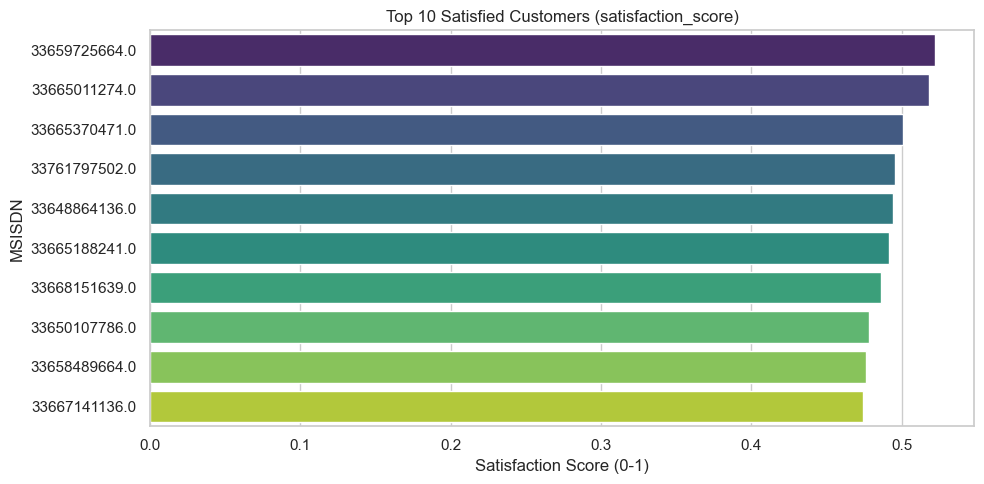

In [4]:
top10 = users.nlargest(10, "satisfaction_score")[["MSISDN", "satisfaction_score", "engagement_score_norm", "experience_score_norm"]]
print("\nTop 10 satisfied customers:")
print(top10.to_string(index=False))

# Plot Top 10 satisfied
plt.figure(figsize=(10,5))
sns.barplot(x="satisfaction_score", y="MSISDN", data=top10, palette="viridis")
plt.title("Top 10 Satisfied Customers (satisfaction_score)")
plt.xlabel("Satisfaction Score (0-1)")
plt.ylabel("MSISDN")
plt.tight_layout()
plt.show()


### Task 4.3 - Regression model to predict satisfaction_score


Regression model (RandomForest) performance: MSE=0.000004, R2=0.9960

Feature importances:
avg_throughput                0.265470
avg_rtt                       0.254723
avg_tcp_retransmission        0.199224
total_session_duration_min    0.153548
sessions_frequency            0.099637
total_traffic_bytes           0.013904
avg_session_duration_min      0.013494
dtype: float64


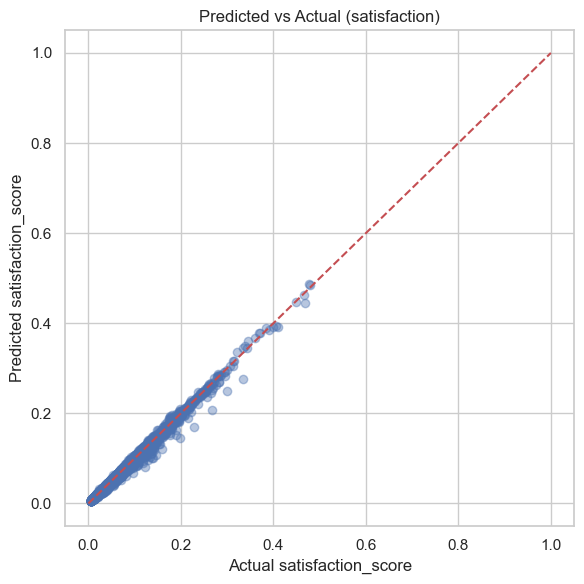

C:\Users\mohan\AppData\Local\Temp\ipykernel_6100\199733228.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="magma")


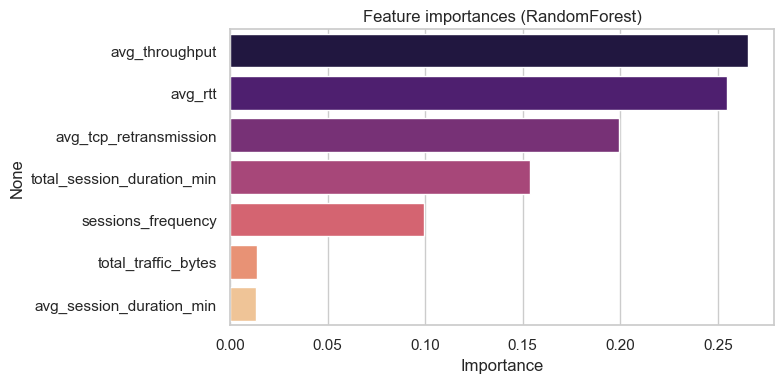

In [5]:

# Features: use engagement features + experience features (scaled)
features_for_model = eng_cols + exp_cols
X = users[features_for_model].fillna(0).values
y = users["satisfaction_score"].values

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale features
scaler_model = StandardScaler().fit(X_train)
X_train_s = scaler_model.transform(X_train)
X_test_s = scaler_model.transform(X_test)

# model choice: RandomForestRegressor (robust)
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=50, random_state=42)
rf.fit(X_train_s, y_train)

y_pred = rf.predict(X_test_s)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nRegression model (RandomForest) performance: MSE={mse:.6f}, R2={r2:.4f}")

# Feature importances
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=features_for_model).sort_values(ascending=False)
print("\nFeature importances:")
print(feat_imp)

# Plot predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([0,1], [0,1], 'r--')
plt.xlabel("Actual satisfaction_score")
plt.ylabel("Predicted satisfaction_score")
plt.title("Predicted vs Actual (satisfaction)")
plt.tight_layout()
plt.show()

# Feature importances plot
plt.figure(figsize=(8,4))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="magma")
plt.title("Feature importances (RandomForest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

### Task 4.4 - KMeans (k=2) on engagement & experience score

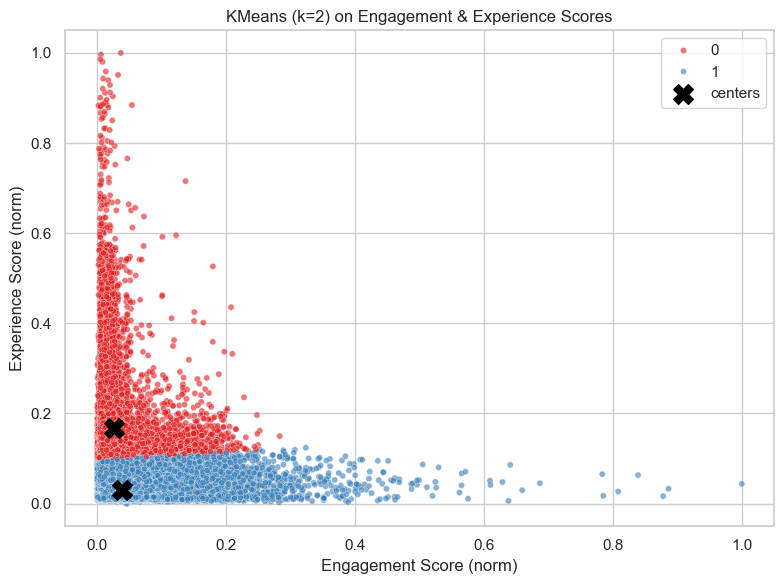

In [6]:

X_scores = users[["engagement_score_norm", "experience_score_norm"]].values
k2 = 2
kmeans_scores = KMeans(n_clusters=k2, random_state=42, n_init=10)
users["score_cluster_k2"] = kmeans_scores.fit_predict(X_scores)

# scatter plot of scores with clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x="engagement_score_norm", y="experience_score_norm", hue="score_cluster_k2", data=users, palette="Set1", alpha=0.6, s=20)
plt.title("KMeans (k=2) on Engagement & Experience Scores")
plt.xlabel("Engagement Score (norm)")
plt.ylabel("Experience Score (norm)")
# plot cluster centers
centers_k2 = kmeans_scores.cluster_centers_
plt.scatter(centers_k2[:,0], centers_k2[:,1], marker='X', s=200, c='black', label='centers')
plt.legend()
plt.tight_layout()
plt.show()

### Task 4.5 - Aggregate average satisfaction & experience score per cluster


Cluster summary (k=2):
                  satisfaction_score_mean  satisfaction_score_count  \
score_cluster_k2                                                      
0                                0.097057                     13099   
1                                0.034562                     93757   

                  experience_score_norm_mean  experience_score_norm_count  \
score_cluster_k2                                                            
0                                   0.168392                        13099   
1                                   0.030784                        93757   

                  engagement_score_norm_mean  engagement_score_norm_count  
score_cluster_k2                                                           
0                                   0.025722                        13099  
1                                   0.038339                        93757  


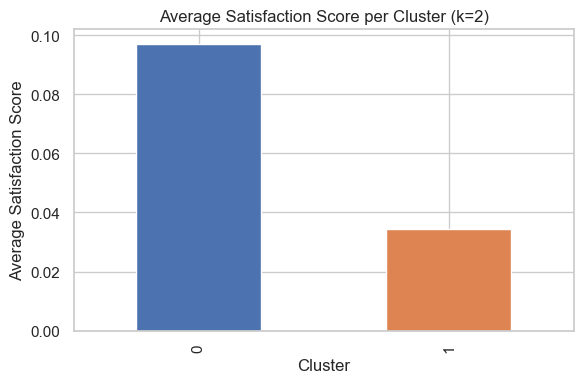

In [7]:

cluster_summary = users.groupby("score_cluster_k2")[["satisfaction_score", "experience_score_norm", "engagement_score_norm"]].agg(["mean","count"])
# flatten columns
cluster_summary.columns = ["_".join(x) for x in cluster_summary.columns]
print("\nCluster summary (k=2):")
print(cluster_summary)

# visualize mean satisfaction per cluster
cluster_means = users.groupby("score_cluster_k2")["satisfaction_score"].mean()
plt.figure(figsize=(6,4))
cluster_means.plot(kind="bar", color=["#4c72b0","#dd8452"])
plt.title("Average Satisfaction Score per Cluster (k=2)")
plt.xlabel("Cluster")
plt.ylabel("Average Satisfaction Score")
plt.tight_layout()
plt.show()


In [8]:
## save in csv for sql data transmission

In [9]:
users.to_csv('final_user_satisfaction.csv', index=False)
users.head()

,MSISDN,sessions_frequency,total_session_duration_ms,total_dl,total_ul,total_traffic_bytes,total_session_duration_min,avg_session_duration_min,avg_tcp_retransmission,avg_rtt,avg_throughput,handset_type,eng_cluster,engagement_score,exp_cluster,experience_score,engagement_score_norm,experience_score_norm,satisfaction_score,score_cluster_k2
0,33601001722.0,1,116720.0,8.426375e+08,36053108.0,8.786906e+08,1.945333,1.945333,2.080991e+07,46.000000,37.0,8.627420e+13,1,1.117716,0,0.321088,0.022878,0.012577,0.017728,1
1,33601001754.0,1,181230.0,1.207552e+08,36104459.0,1.568596e+08,3.020500,3.020500,2.080991e+07,30.000000,48.0,3.553261e+13,2,2.347488,0,0.414141,0.056273,0.016607,0.036440,1
2,33601002511.0,1,134969.0,5.566597e+08,39306820.0,5.959665e+08,2.249483,2.249483,2.080991e+07,109.795706,48.0,3.561271e+13,2,1.299668,0,0.367248,0.027819,0.014576,0.021198,1
3,33601007832.0,1,49878.0,4.019932e+08,20327526.0,4.223207e+08,0.831300,0.831300,1.066000e+03,69.000000,204.0,3.520491e+13,1,0.572260,0,1.190534,0.008067,0.050234,0.029150,1
4,33601008617.0,2,37104.0,1.363130e+09,94280527.0,1.457411e+09,0.618400,0.309200,1.507977e+07,57.000000,20197.5,3.530681e+13,1,2.184609,0,1.097943,0.051850,0.046224,0.049037,1
